In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import csv
import markov_clustering as mc
from matplotlib.pylab import cm, axis
import math

### Read in binary purchase vectors as DataFrame and convert to a Pearson's Correlation matrix
The generation of these vectors has been handled using Rust, in `../rust_backend/src/main.rs`

In [2]:
# time the read operation
start = time.time()
vectors = pd.read_pickle('data/rust_vectors_product_category_no_fuel.pkl')
read_time = time.time() - start



print(f'Read in {read_time:.2f} seconds.\n{vectors.shape[0]:,}'+
      f' binary purchase vectors with {vectors.shape[1]:,} elements each.')

Read in 1.15 seconds.
1,362,617 binary purchase vectors with 38 elements each.


In [3]:
# Generate correlation matrix from purchase vectors (Pearson's)
corr = vectors.corr()

In [4]:
cols = list(vectors.columns)

for i in range(len(cols)):
    print(f'{i}: {cols[i]}')

0: lubricant
1: several
2: filters
3: additives and fluids
4: cigarettes
5: accessories
6: popsicle and ice creams
7: chewing gum and candy
8: chips
9: the bakery
10: juices and soft drinks
11: condom
12: biscuits and wafer
13: flavoring
14: pickets
15: cold alcoholic beverages
16: canisters
17: chocolates
18: extinguisher
19: energy
20: derivatives peanuts
21: coal
22: dairy products and materials
23: salted biscuit
24: cereals
25: personal hygiene
26: water
27: hot alcoholic beverages
28: slippers
29: toys
30: covers
31: pastas
32: popcorn
33: sweet coconut james
34: batteries
35: mate herb
36: perfumery
37: tea juice cafe in powder


# Correlation Matrix
Since the correlation matrix has to be diagonally symmetrical, we need only look at one triangle.

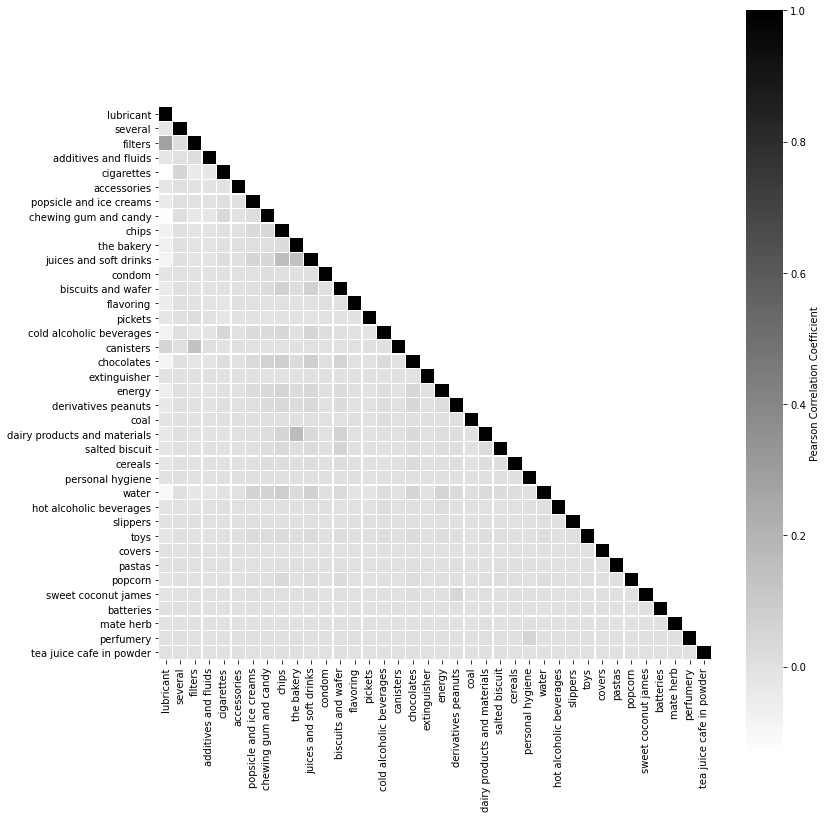

In [5]:
# Plot the triangle
fig, ax = plt.subplots(figsize=(12,12))
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
sns.heatmap(df_lt, cmap='binary', square=True, linewidths=0.2, cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.tight_layout()
plt.savefig('../images/correlation.png')
plt.show()

### Distance Function
We need a minimum spanning tree, which implies that the smaller the edge value, 
the higher the correlation between the nodes it connects.

To do this, we apply the distance function $\sqrt{2(1-x)}$ over the correlation values to transform them as such

In [2]:
# A vectorized distance function that can be 
# applied simultaneously over the entire matrix
def dfunc(x):
    return np.sqrt(2 * (1 - np.abs(x)))

To demonstrate this, this graph shows the effect of the distance function on the correlation values

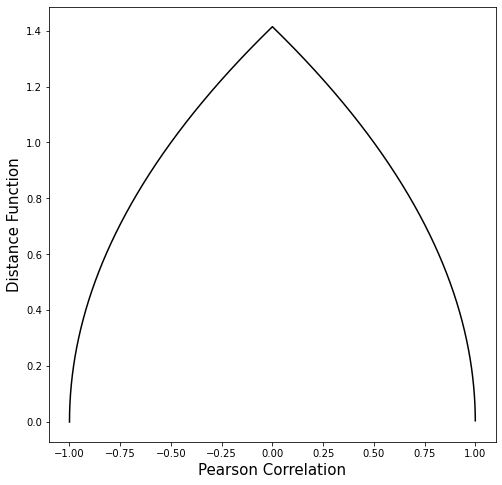

In [3]:
temp = np.arange(-1, 1, 0.00001)
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(temp, dfunc(temp), 'k')
plt.ylabel("Distance Function", fontsize=15)
plt.xlabel("Pearson Correlation", fontsize=15)
#plt.title("The effect of the distance function.", fontsize=15)
plt.savefig('../images/distance_function.png')
plt.show()

# Graph Generation
Here we will generate and illustrate both the complete graph and the resulting minimum spanning tree.

In [24]:
# Extract column names from vectors dataframe
columns = vectors.columns

# Dictionary used to map each node index to its respective label
labels = {i:columns[i] for i in range(len(columns))}


# Convert the correlation dataframe to a numpy matrix and apply distance function
corr_distanced = np.array(dfunc(corr))

# Generate a graph from the correlation matrix, reading it in as an adjacency matrix
G = nx.from_numpy_matrix(corr_distanced)

# Generate the minimum spanning tree from the above graph
MST = nx.minimum_spanning_tree(G)

### Plot the resulting graphs

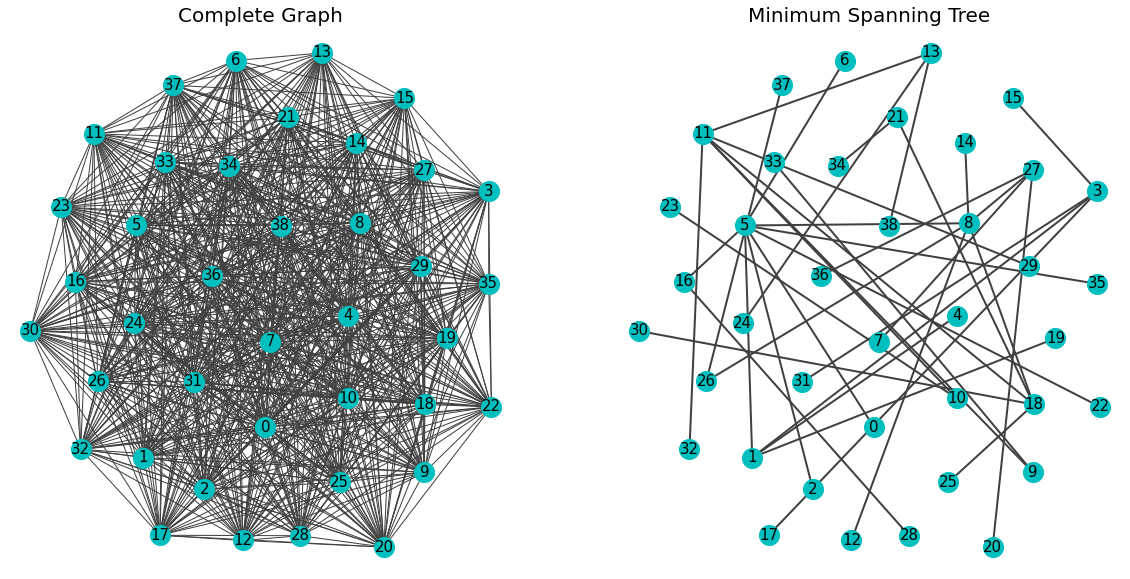

In [25]:
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Set titles
ax[0].set_title("Complete Graph", fontsize=20)
ax[1].set_title("Minimum Spanning Tree", fontsize=20)

# Fixed positional layout for nodes
pos = nx.spring_layout(G)

# Collection of plotting arguments common amongst the two functions
kwargs= dict(pos=pos, with_labels=True, node_color='c',node_size=400, edge_color='0.25', font_size=15)

# Plot the complete graph
nx.draw(G, ax=ax[0], width=1, **kwargs)

# Plot the MSt
nx.draw(MST, ax=ax[1], width=2, **kwargs)

# Cluster Identification 
Markov Clustering is used to identify potential clusters within the graph.

### Parameter Selection
To identify the ideal inflation value to use, we test values from 1.5 to 2.6, using the modularity of the resulting matrix to assess the values, the higher the better. The best inflation score is used to identify the optimal clusters.

In [28]:
def get_optimal_clusters(matrix):
    best_score = (-math.inf)
    best_inflation = None
    best_clusters = None
    inflation_ranges = np.arange(1.5, 2.6, 0.1)
    for inflation in inflation_ranges:
        result = mc.run_mcl(matrix, inflation=inflation)
        clusters = mc.get_clusters(result)
        Q = mc.modularity(matrix=result, clusters=clusters)
        if Q > best_score:
            best_score = Q
            best_inflation = inflation
            best_clusters = clusters
    print(best_inflation)
    return best_clusters

In [30]:
# Extract sparse matrix from MST
matrix = nx.to_scipy_sparse_matrix(MST)

# Identify clusters
clusters = get_optimal_clusters(matrix)

# map node to cluster id for colors
cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
colors = [cluster_map[i] for i in range(len(MST.nodes()))]

1.6


### Plot the MST and the Clustered MST 

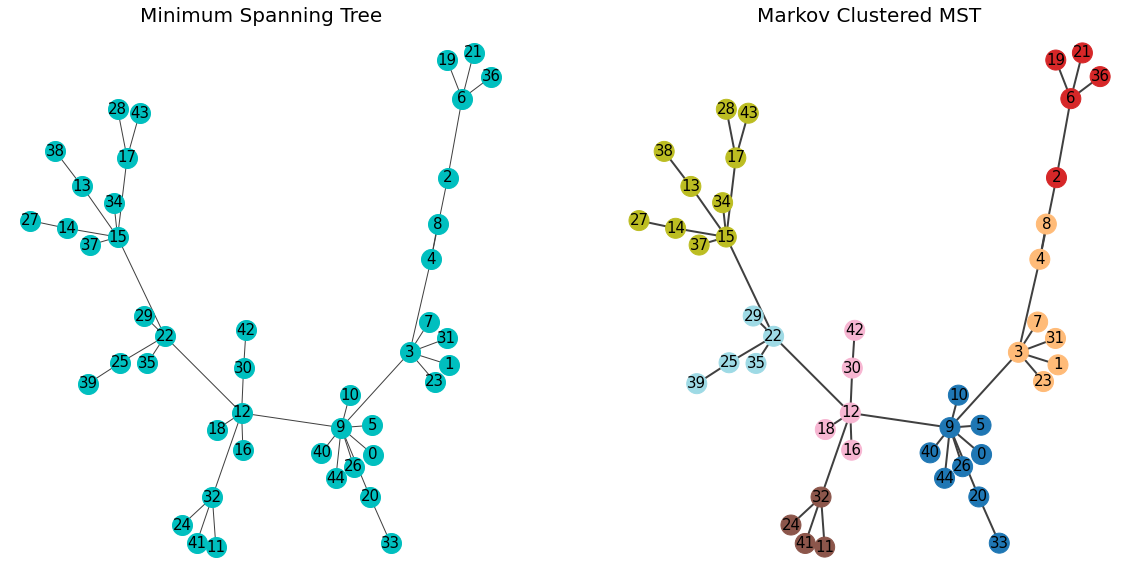

In [29]:
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Set titles
ax[0].set_title("Minimum Spanning Tree", fontsize=20)
ax[1].set_title("Markov Clustered MST", fontsize=20)

# Fixed positional layout for nodes
pos = nx.spring_layout(MST)

# Collection of plotting arguments common amongst the two functions
kwargs= dict(pos=pos, with_labels=True,node_size=400, edge_color='0.25', font_size=15)

# Plot the MST
nx.draw(MST, ax=ax[0], node_color='c', width=1, **kwargs)

# Plot the Markov Clustered MST
nx.draw(MST, node_color=colors, cmap=cm.tab20, ax=ax[1], width=2, **kwargs)

### Print Clusters Identified

In [16]:
for x, cluster in enumerate(clusters):
    if len(cluster) <= 5: # Don't print long ones
        named = [columns[i] for i in cluster]
        print(f'Cluster #{x}: {", ".join(named)}\n')

Cluster #2: lubricant, filters, pickets, canisters, covers

Cluster #3: popsicle and ice creams, energy, water, mate herb

Cluster #4: chewing gum and candy, condom, flavoring, personal hygiene, perfumery

Cluster #6: chocolates, derivatives peanuts, cereals, toys, sweet coconut james

